In [1]:
import torch
from torch import nn
import einops
from tqdm import tqdm

In [2]:
# Define models
class NonlinearModel(nn.Module):
    def __init__(self, n, m):
        super().__init__()
        self.w = nn.Parameter(torch.empty((n, m)))
        nn.init.kaiming_normal_(self.w)
        self.b = nn.Parameter(torch.zeros(n))
        self.activ = nn.ReLU()

    def forward(self, x):
        h = einops.einsum(x, self.w, "b n, n m -> b m")
        out = self.activ(einops.einsum(self.w, h, "n m, b m -> b n")  + self.b)
        return out

class LinearModel(nn.Module):
    def __init__(self, n, m):
        super().__init__()
        self.w = nn.Parameter(torch.empty((n, m)))
        nn.init.xavier_normal_(self.w)
        self.b = nn.Parameter(torch.zeros(n))

    def forward(self, x):
        h = einops.einsum(x, self.w, "b n, n m -> b m")
        out = einops.einsum(self.w, h, "n m, b m -> b n")  + self.b
        return out

In [3]:
import numpy as np
import torch

def generate_synthetic_data(batch_size, num_features, sparsity):
    data = np.random.rand(batch_size, num_features)
    mask = (np.random.rand(batch_size, num_features) >= sparsity).astype(float)
    data *= mask
    return torch.tensor(data, dtype=torch.float32)

In [4]:
num_features = 20
hidden_dim = 5
sparsity = 0
importance = torch.tensor([0.9**i for i in range(1, num_features+1)])

In [5]:
nonlinear_model = NonlinearModel(num_features, hidden_dim)
linear_model = LinearModel(num_features, hidden_dim)

In [6]:
# Training parameters
learning_rate = 1e-3
batch_size = 1024
steps = 10_000

def train_model(model):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    pbar = tqdm(range(steps), position=0, leave=True)
    for _ in pbar:
        batch = generate_synthetic_data(batch_size, num_features, sparsity)
        optimizer.zero_grad()
        output = model(batch) 
        loss = torch.mean(importance * (batch - output)**2)
        loss.backward()
        optimizer.step()
        
        pbar.set_description(f"Loss: {loss.item():.4f}")

print("Training NonlinearModel:")
train_model(nonlinear_model)

print("\nTraining LinearModel:")
train_model(linear_model)

Training NonlinearModel:


Loss: 0.0181: 100%|██████████| 10000/10000 [00:28<00:00, 357.11it/s]



Training LinearModel:


Loss: 0.0178: 100%|██████████| 10000/10000 [00:27<00:00, 358.32it/s]


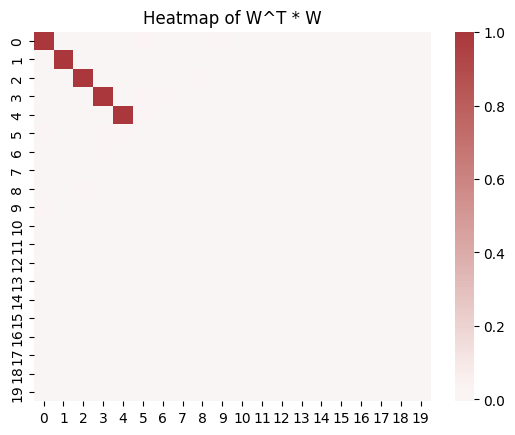

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the matrix W^T * W
matrix = linear_model.w.detach().mm(linear_model.w.detach().t()).numpy()

sns.heatmap(matrix, cmap='vlag', annot=False, center=0)
plt.title("Heatmap of W^T * W")
plt.show()

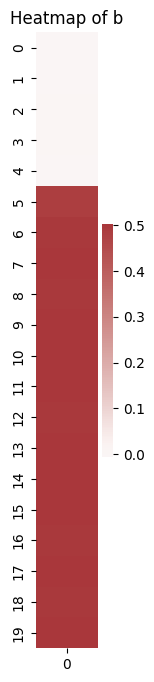

In [26]:
# Reshape the bias to make it 2-dimensional
bias_2d = linear_model.b.detach().numpy().reshape(-1, 1)

plt.figure(figsize=(1, 8))
sns.heatmap(bias_2d, cmap='vlag', annot=False, center=0)
plt.title("Heatmap of b")
plt.show()